In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from shapely.geometry import Polygon, Point
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn import metrics

import itertools
from itertools import cycle
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import single, cophenet, linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

In [2]:
os.getcwd()

'C:\\Users\\Armando\\OneDrive\\Desktop\\Project-data-mining'

In [3]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json"
covidItalyRegioniDataset = pd.read_json(url)
var_of_interest = covidItalyRegioniDataset[['data','ricoverati_con_sintomi' ,'terapia_intensiva' ,'totale_ospedalizzati','isolamento_domiciliare']]
# create an array with all the values from the variable that we have chosen
X = covidItalyRegioniDataset[['ricoverati_con_sintomi' ,'terapia_intensiva' ,'totale_ospedalizzati','isolamento_domiciliare']].values
# Standardize features by removing the mean and scaling to unit variance
stdScaler = StandardScaler()
X_std = stdScaler.fit_transform(X)

In [4]:
X_std

array([[-0.52049271, -0.54111219, -0.52445316, -0.39424416],
       [-0.52049271, -0.54111219, -0.52445316, -0.39424416],
       [-0.52049271, -0.54111219, -0.52445316, -0.39424416],
       ...,
       [-0.32823635, -0.46501315, -0.34313658,  0.03306209],
       [-0.47172524, -0.51574584, -0.47785311, -0.32997649],
       [ 0.69681832,  0.47354161,  0.67698101,  3.23588721]])

In [5]:
print(var_of_interest.info())
var_of_interest.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15057 entries, 0 to 15056
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   data                    15057 non-null  object
 1   ricoverati_con_sintomi  15057 non-null  int64 
 2   terapia_intensiva       15057 non-null  int64 
 3   totale_ospedalizzati    15057 non-null  int64 
 4   isolamento_domiciliare  15057 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 588.3+ KB
None


,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare
0,2020-02-24T18:00:00,0,0,0,0
1,2020-02-24T18:00:00,0,0,0,0
2,2020-02-24T18:00:00,0,0,0,0
3,2020-02-24T18:00:00,0,0,0,0
4,2020-02-24T18:00:00,10,2,12,6


In [6]:
rows, cols = var_of_interest.shape
variability = []
for column in var_of_interest.columns:
    variability.append(len(var_of_interest[column].unique())) # quanti valori unici ci sono
dataInfo = {'dataType': var_of_interest.dtypes,
            'variability': variability,
            'missingValues': var_of_interest.isna().sum(),
            'missingValuesInRelative': var_of_interest.isna().sum()/rows,
            'missingValuesInPercentual': var_of_interest.isna().sum()*(100/rows)}
dataInformation = pd.DataFrame(data=dataInfo)
dataInformation.head(5)

,dataType,variability,missingValues,missingValuesInRelative,missingValuesInPercentual
data,object,717,0,0.0,0.0
ricoverati_con_sintomi,int64,2536,0,0.0,0.0
terapia_intensiva,int64,598,0,0.0,0.0
totale_ospedalizzati,int64,2725,0,0.0,0.0
isolamento_domiciliare,int64,9168,0,0.0,0.0


In [7]:
queryRetrivNumericalData = (dataInformation['dataType']=='int64')| (dataInformation['dataType']=='float64')
numericalData = set(dataInformation[queryRetrivNumericalData].index)

In [8]:
numericalData

{'isolamento_domiciliare',
 'ricoverati_con_sintomi',
 'terapia_intensiva',
 'totale_ospedalizzati'}

In [9]:
var_of_interest

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare
0,2020-02-24T18:00:00,0,0,0,0
1,2020-02-24T18:00:00,0,0,0,0
2,2020-02-24T18:00:00,0,0,0,0
3,2020-02-24T18:00:00,0,0,0,0
4,2020-02-24T18:00:00,10,2,12,6
...,...,...,...,...,...
15052,2022-02-09T17:00:00,1369,115,1484,274234
15053,2022-02-09T17:00:00,1252,96,1348,97394
15054,2022-02-09T17:00:00,205,9,214,16795
15055,2022-02-09T17:00:00,52,3,55,2526


### We construct a heatmap in order to see if we have NaN values in our variables

<AxesSubplot:>

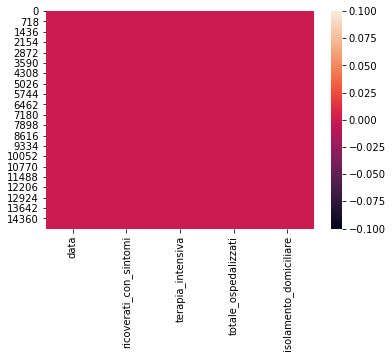

In [10]:
sns.heatmap(data=var_of_interest.isna())

In [11]:
var_of_interest.isna()

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
15052,False,False,False,False,False
15053,False,False,False,False,False
15054,False,False,False,False,False
15055,False,False,False,False,False


### Then, we construct the covariance matrix(a square matrix) in order to see the correlation between variables and then, we create a heatmap using the data in the covariance matrix

In [12]:
cov_matrix = var_of_interest.corr()
cov_matrix

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare
ricoverati_con_sintomi,1.000000,0.959725,0.999604,0.462838
terapia_intensiva,0.959725,1.000000,0.967253,0.405910
totale_ospedalizzati,0.999604,0.967253,1.000000,0.458818
isolamento_domiciliare,0.462838,0.405910,0.458818,1.000000


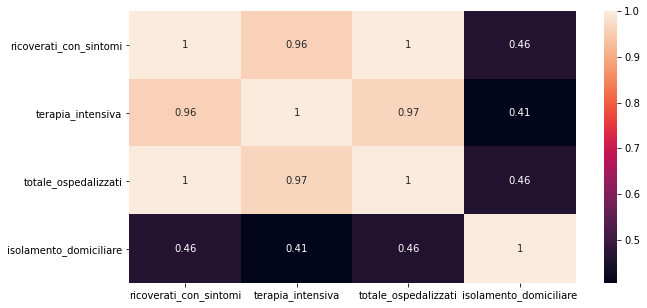

In [13]:
plt.figure(figsize=(10,5))
sns.heatmap(data=cov_matrix, annot=True)
plt.show()

### We construct a regression and we plot data and a linear regression model fit to see the relationship between two variables and estimate one variable based on the other one. Otherwise construct an histogram to show the distributions of variables.


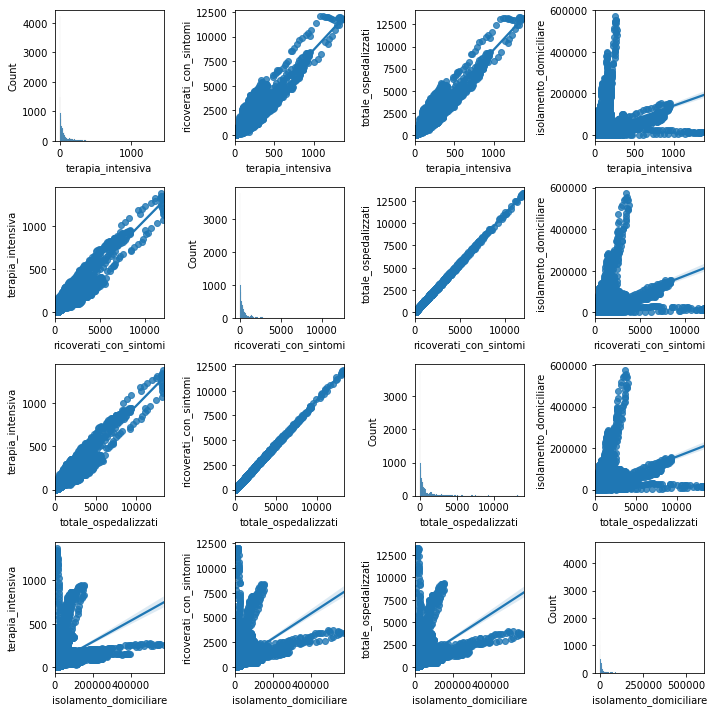

In [14]:
figReg, axesReg = plt.subplots(nrows=4,ncols=4, figsize=(10,10))
for i, column0 in zip(np.arange(4), numericalData):
    for j, column1 in zip(np.arange(4), numericalData):
        if(column0!=column1):
            sns.regplot(x=column0, y=column1, data = covidItalyRegioniDataset, ax = axesReg[i,j])
        else:
             sns.histplot(covidItalyRegioniDataset[column0], ax = axesReg[i,j])
    figReg.tight_layout()
plt.show()

### We take reference from these examples: <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py" target="_blank">Silhouette Coefficient</a> and <a href="https://www.developersmaggioli.it/blog/apprendimento-non-supervisionato-clustering-k-means/#:~:text=E%E2%80%99%20per%C3%B2%20possibile%20utilizzare%20un%20metodo%20maggiormente%20oggettivo,ogni%20centroide%20ed%20i%20punti%20del%20proprio%20cluster." target="_blank">Elbow Method</a>
### The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
### Elbow Method: In practice, the K-means is iterated for different values of K and each time the sum of squared distances between each centroid and the points of its cluster is calculated. By plotting the values of K (horizontal axis) and the values of the sum of the squared distances (vertical axis), a graph similar to the one in the figure is obtained. This graph should be read from right to left. Find the point where the curve tends to rise most consistently. 
### As we can see, from the Silhouette Coefficient and Elbow Method we need to choose k=2.

In [15]:
silhoutteValutations = []
SSD = []
K = np.arange(2,11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_std)
    silhoutteValutations.append(silhouette_score(X_std, kmeans.labels_, metric='euclidean'))
    SSD.append(kmeans.inertia_)

Text(0, 0.5, 'SSD')

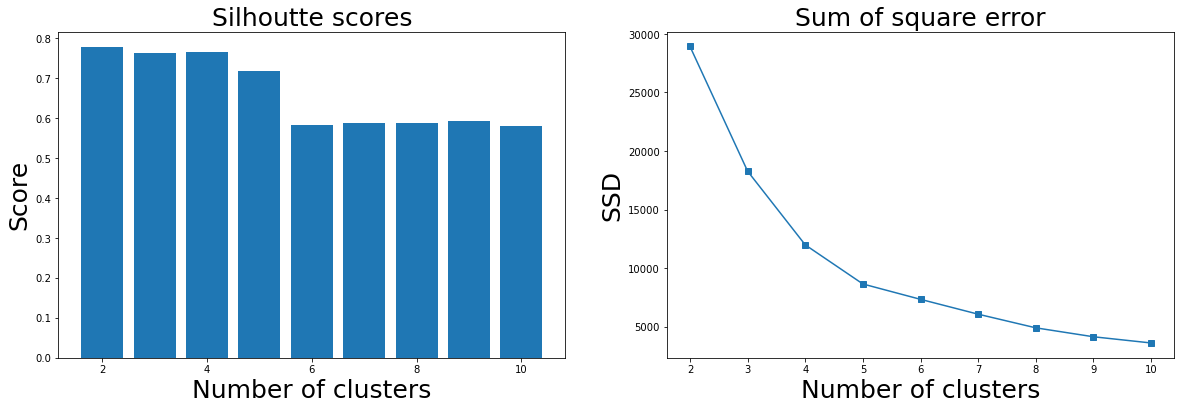

In [16]:
figKM, axesKM = plt.subplots(nrows=1,ncols=2, figsize = (20,6))
axesKM[0].bar(K,silhoutteValutations)
axesKM[0].set_title("Silhoutte scores", fontsize=25)
axesKM[0].set_xlabel('Number of clusters', fontsize= 25)
axesKM[0].set_ylabel('Score', fontsize= 25)
axesKM[1].plot(K,SSD, marker='s')
axesKM[1].set_title("Sum of square error", fontsize= 25)
axesKM[1].set_xlabel('Number of clusters', fontsize=25)
axesKM[1].set_ylabel('SSD', fontsize= 25)

### A time series is a set of observations, successive in time, of a variable. Time Series Clustering is an unsupervised data mining technique for organizing data points into groups based on their similarity.

In [17]:
columnsSeries ={0:'ricoverati_con_sintomi',
               1: 'terapia_intensiva',
               2:'totale_ospedalizzati',
               3:'isolamento_domiciliare'}

In [18]:
list(itertools.combinations(range(4), 2))

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

### The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

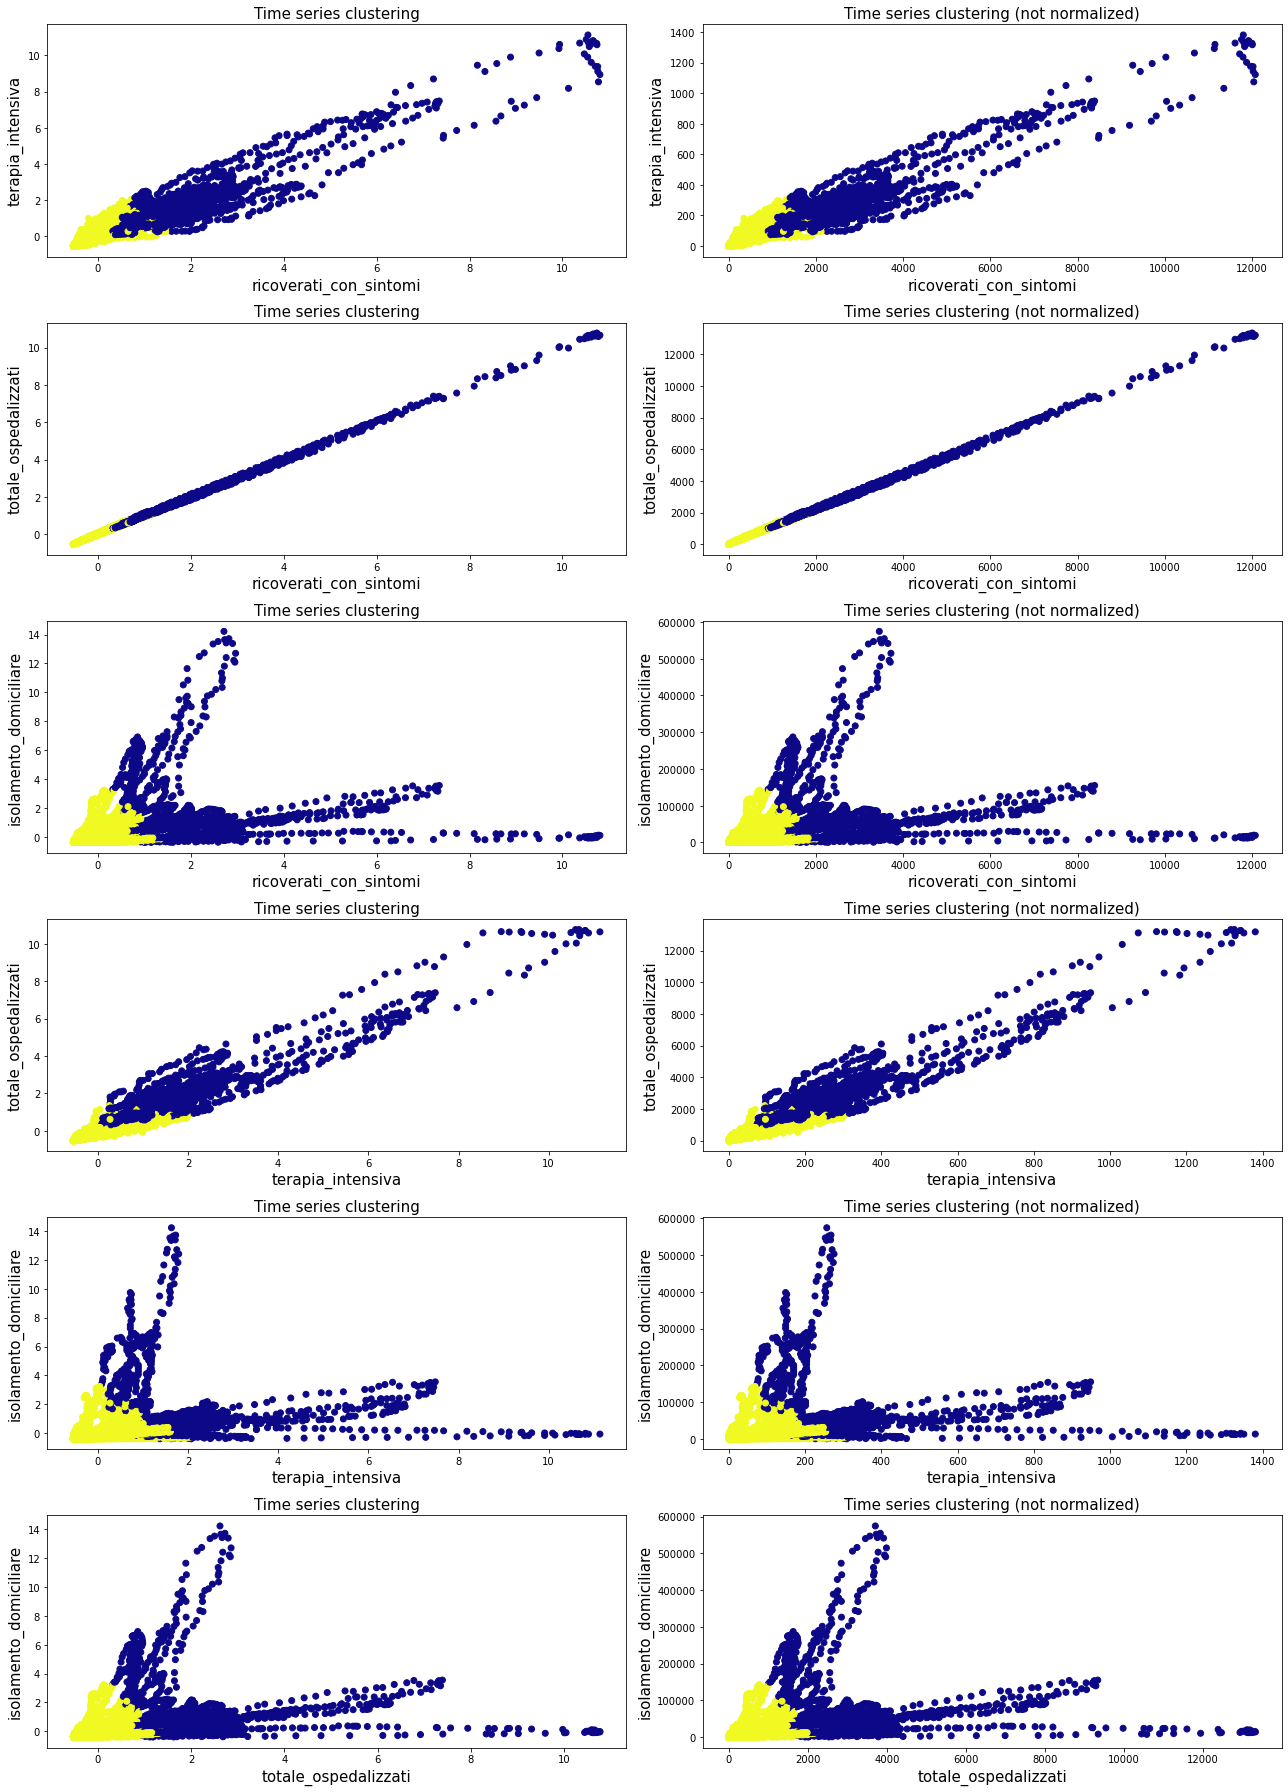

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_std)
labels_2 = kmeans.labels_
figKM2, axesKM2 = plt.subplots(nrows=6,ncols=2, figsize = (18,25))
for i, tuples in zip(np.arange(6), list(itertools.combinations(range(4), 2))):
     axesKM2[i][0].scatter(X_std[:,tuples[0]], X_std[:, tuples[1]], c = labels_2, cmap = 'plasma')
     axesKM2[i][0].set_title("Time series clustering", fontsize=15)
     axesKM2[i][0].set_xlabel(columnsSeries[tuples[0]], fontsize= 15)
     axesKM2[i][0].set_ylabel(columnsSeries[tuples[1]], fontsize= 15)
     
     axesKM2[i][1].scatter(X[:,tuples[0]], X[:, tuples[1]], c = labels_2, cmap = 'plasma')
     axesKM2[i][1].set_title("Time series clustering (not normalized)", fontsize=15)
     axesKM2[i][1].set_xlabel(columnsSeries[tuples[0]], fontsize= 15)
     axesKM2[i][1].set_ylabel(columnsSeries[tuples[1]], fontsize= 15)
    
     figKM2.tight_layout()    

### We are creating a group based on labels and then we calculate the mean in order to understand to see the differences between clusters

In [20]:
clusteringIntepretation = pd.DataFrame(data = X, columns=['ricoverati_con_sintomi' ,'terapia_intensiva' ,'totale_ospedalizzati','isolamento_domiciliare'])
clusteringIntepretation['labels'] = labels_2
clusteringIntepretation.groupby('labels').mean()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare
labels,,,,
0,2834.850087,305.789657,3140.639744,81138.442185
1,260.779694,32.792367,293.572061,7024.348980


### There are 2 groups, the first group identifies the initial phase of the infection where the phase is at the initial and did not have an exponential trend yet, the second group identifies the exponential phase. 

In [21]:
clusteringIntepretation.groupby('labels').count()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare
labels,,,,
0,1721,1721,1721,1721
1,13336,13336,13336,13336


### Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.
### The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together.

In [22]:
silhoutteValutations = []
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')  
cluster.fit_predict(X_std)
labelsWard = cluster.labels_
K = np.arange(2,10)
for k in K:
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')
    cluster.fit(X_std)
    silhoutteValutations.append(silhouette_score(X_std, cluster.labels_, metric='euclidean'))

Text(0, 0.5, 'scores')

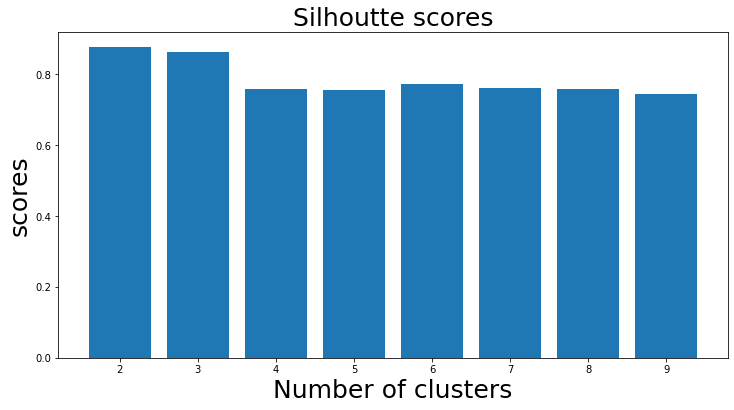

In [23]:
plt.figure(figsize=(12,6))
plt.bar(K,silhoutteValutations)
plt.title("Silhoutte scores", fontsize=25)
plt.xlabel('Number of clusters', fontsize= 25)
plt.ylabel('scores', fontsize= 25)

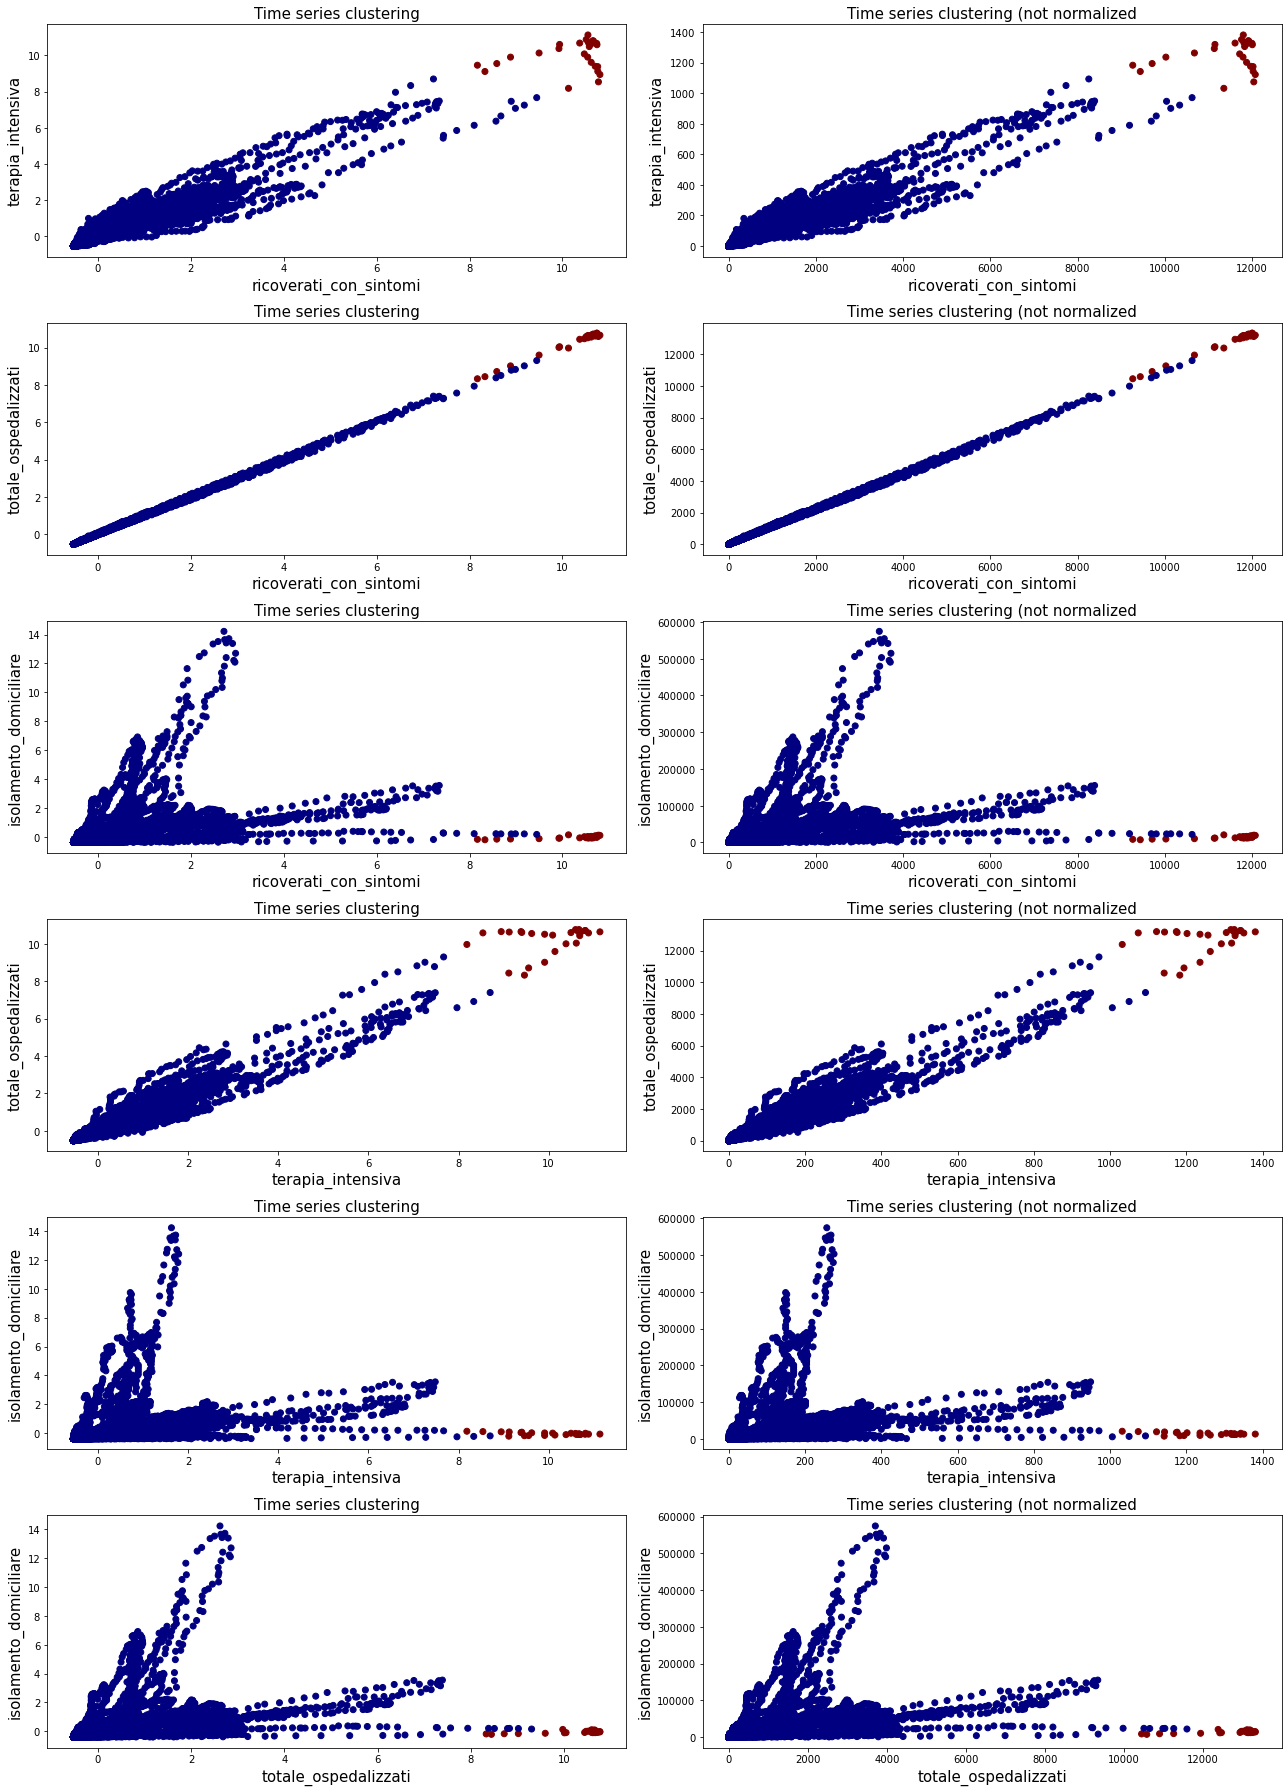

In [24]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')  
cluster.fit_predict(X_std)
labelsHC = cluster.labels_
figHC, axesHC = plt.subplots(nrows=6,ncols=2, figsize = (18,25))
for i, tuples in zip(np.arange(6), list(itertools.combinations(range(4), 2))):
     axesHC[i][0].scatter(X_std[:,tuples[0]], X_std[:, tuples[1]], c = labelsHC, cmap = 'jet')
     axesHC[i][0].set_title("Time series clustering", fontsize=15)
     axesHC[i][0].set_xlabel(columnsSeries[tuples[0]], fontsize= 15)
     axesHC[i][0].set_ylabel(columnsSeries[tuples[1]], fontsize= 15)
     axesHC[i][1].scatter(X[:,tuples[0]], X[:, tuples[1]], c = labelsHC, cmap = 'jet')
     axesHC[i][1].set_title("Time series clustering (not normalized", fontsize=15)
     axesHC[i][1].set_xlabel(columnsSeries[tuples[0]], fontsize= 15)
     axesHC[i][1].set_ylabel(columnsSeries[tuples[1]], fontsize= 15)
     figHC.tight_layout()   

### The DBScan algorithm is not applied due to the different density present in the data(dpc-covid19-ita-regioni.json). For this I have chosen another dataset(generated by sklearn.datasets.make_blobs) in order to demonstrate the idea of DBSCAN algorithm.
###  sklearn.datasets.make_blobs generate isotropic Gaussian blobs for clustering. The make_blobs() function draws samples from a special Gaussian mixture model. A general Gaussian mixture model with k clusters has a density of the form: 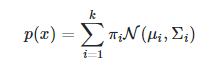 where πi≥0 are the weights of each cluster with ∑ki=1πi=1, μi are the cluster centers, and Σi are the cluster covariances. Here N(μi,Σi) refers to the normal Gaussian density with mean μi and covariance Σi. In particular, for the make_blobs() function, each cluster or component has equal probability of being sampled πi=1/k. Isotropic refers to the fact that the covariance matrices will all be diagonal 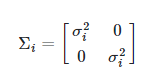 with σi being the standard deviation that is passed in. By default, all clusters will have the same standard deviation. A Gaussian mixture model is not Gaussian unless there is only one cluster, which is why your plots don't look Gaussian, but rather a combination of Gaussians.

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Silhouette Coefficient: 0.626


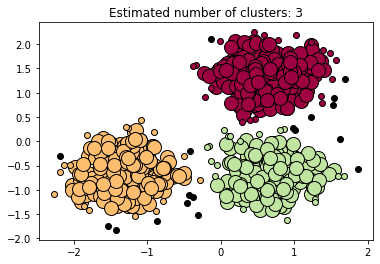

In [25]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()